# A2 - Clustering and Visualization

### Imports

In [1]:
import os
from math import pi
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import umap
from IPython.display import Image

### Functions

In [69]:
'''
aggregate all data
Inputs: [path to CSV folders]
Returnes: CSV of all CSVs fould in set folder
'''
def aggregate(path, conf_thresh):

    data = []
    files = glob.glob(path + "/*.csv")
    for file in files:
        temp_df = preprocess(file, conf_thresh)
        data.append(temp_df)

    df = pd.concat(data, axis=0, ignore_index=True)
    df = df.sort_values(['csv_name', 'frame'])

    return df


'''
Export BIC Graph
Inputs:[Dataframe, name of exported file, x axis (number of components)]
'''
def bic_analysis(X_data, file_name, n_comp):
    # Find # of components
    n_components = np.arange(1, n_comp+1)
    models = [GMM(n, covariance_type='full', random_state=seed).fit(X_data) \
              for n in n_components]
    plt.clf()
    plt.close()
    plt.plot(n_components, [m.bic(X_data) for m in models], label='BIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.title('BIC for ' + file_name)

    # output
    #plt.show()
    # save
    plt.savefig(file_name + "_bic.png")
    plt.clf()
    plt.close()

'''
find video frames at means and export as jpg.
puts gmm1 frames in mean_frames_1 folder
puts gmm2 frames in mean_frames_2 folder
Inputs: [dataframe, path to gifs, model type]
'''
def extract_mean_frames(data, path, type):
    # type 1 is for gmm1
    # type 2 is for gmm2
    if type == 1:
        num_videos = data.shape[0]
        for i in range(num_videos):
            csv = data['csv_name'].values[i]
            video = csv.split(".")[0] + ".mp4"
            video_name = path + str(video)
            frame = data['frame'].values[i]+1
            frame_str = frame
            frame_name = "mean_frames_1/C" + str(i) + "_mframe.jpg"
            select_str = "\"select=eq(n\\," + str(frame) + ")\""
            print(select_str)
            #os.system("ffmpeg -i " + path + str(video) + " -vf \"select=eq(n\, " + str(frame) + ")\" -vframes 1 " + frame_name + " -y")
            !ffmpeg -i {video_name} -vf {select_str} -vframes 1 {frame_name} -y
    elif type == 2:
        num_videos = data.shape[0]
        for i in range(num_videos):
            csv = data['csv_name'].values[i]
            video = csv.split(".")[0] + ".mp4"
            frame = data['frame'].values[i]+1
            frame_name = "mean_frames_2/C" + str(i) + "_mframe.jpg"
            os.system("ffmpeg -i " + path + str(video) + " -vf \"select=eq(n\, " + str(frame) + ")\" -vframes 1 " + frame_name + " -y")
    else: print("wrong type set for extract_mean_frames")
    print("Frame Extraction Complete")
        
'''
find dataframe rows for each mean
- calculates differences between mean AUs and dataframe AUs, and sums the values in diff_sum
- locates row with lowest diff_sum value
input: [dataframe, gmm mean array, type of model]
Returns: dataframe of means
'''
def find_mean_frames(data, means, type):
    # type: 1 is for gmm1
    # type: 2 is for gmm2
    if type == 1:
        dfs = []
        num = means.shape[0]
        #print(num)
        for i in range(num):
            data['diff_sum'] = np.abs(data['AU01_r']-means[i][0]) \
                                 + np.abs(data['AU02_r']-means[i][1]) \
                                 + np.abs(data['AU04_r']-means[i][2]) \
                                 + np.abs(data['AU05_r']-means[i][3]) \
                                 + np.abs(data['AU06_r']-means[i][4]) \
                                 + np.abs(data['AU07_r']-means[i][5]) \
                                 + np.abs(data['AU09_r']-means[i][6]) \
                                 + np.abs(data['AU10_r']-means[i][7]) \
                                 + np.abs(data['AU12_r']-means[i][8]) \
                                 + np.abs(data['AU04_r']-means[i][9]) \
                                 + np.abs(data['AU15_r']-means[i][10]) \
                                 + np.abs(data['AU17_r']-means[i][11]) \
                                 + np.abs(data['AU20_r']-means[i][12]) \
                                 + np.abs(data['AU23_r']-means[i][13]) \
                                 + np.abs(data['AU25_r']-means[i][14]) \
                                 + np.abs(data['AU26_r']-means[i][15]) \
                                 + np.abs(data['AU45_r']-means[i][16])

            mean_df = data[data.p_label == i]
            mean_df = mean_df[data.probs >= prob_thresh]

            idx = mean_df[['diff_sum']].idxmin()
            #print(idx)

            mean_df = mean_df.drop(columns=['face_id', 'confidence',
                                            'success']) #, 'diff_sum'])
            mean_df = mean_df.loc[idx]
            dfs.append(mean_df)
            returned_dataframe = pd.concat(dfs)

    if type == 2:
        dfs = []
        num = means.shape[0]
        print(num)
        for i in range(num):
            data['diff_sum'] = np.abs(data['dim1']-means[i][0]) \
                                 + np.abs(data['dim2']-means[i][1]) \

            mean_df = data[data.p_label_umap == i]
            mean_df = mean_df[data.probs_umap >= prob_thresh]

            idx = mean_df[['diff_sum']].idxmin()
            #print(idx)

            #mean_df = mean_df.drop(columns=['face_id', 'confidence',
                                          #  'success']) #, 'diff_sum'])
            mean_df = mean_df[['csv_name', 'frame','dim1', 'dim2',
                'p_label_umap', 'probs_umap', 'diff_sum']]
            mean_df = mean_df.loc[idx]
            dfs.append(mean_df)
            returned_dataframe = pd.concat(dfs)

        else: "wrong type set for find_mean_frames()"

    #print("test_df:\n", mean_df.loc[idx])
    return returned_dataframe

'''
used to classify test gifs
- uses likelihood threshold set in parameter section
- uses predicted probability threshold set in parameter section
inputs: [dataframe, model type]
returns: most probable label as integer, and dictionary of confidence for each label
'''
# --- --- find label confidence
def label_confidence(data, type):
    # type 1: GMM1
    # type 2: GMM2 (UMAP)
    conf_dict = {}
    data = data[data.likelihood_diff <= llh_thresh]

    if type == 1:
        data = data[data.probs >= pred_prob_thresh]
        num_values = data.shape[0]
        key = list(data['p_label'].value_counts().index.values)
        value = list(data['p_label'].value_counts().values)

    elif type == 2:
        #print(data)
        data = data[data.probs_umap >= pred_prob_thresh]
        num_values = data.shape[0]
        key = list(data['p_label_umap'].value_counts().index.values)
        value = list(data['p_label_umap'].value_counts().values)

    for i in range(len(key)):
        conf_dict[key[i]] = (value[i]/num_values).round(2)
    max_conf = 0
    for i in conf_dict:
        if conf_dict[i]>max_conf: max_conf = i
    #print(type(key), type(value))
    return max_conf, conf_dict

'''
Creates a SIRE graph for each AU value
- graph shows intensities from 1 to 3 (even though values go up to 5)
inputs: [gmm means, number of clusters, data-type (either gmm means or selected frame df), export folder name
           model type]
exports: n graphs
'''
# radar chart code adapted from:
# https://python-graph-gallery.com/390-basic-radar-chart/
def make_radar(means, n_comp, data_type, path, gmm_type):
    # 0: use mean data
    # 1: use df data

    if data_type == 0 and gmm_type == 1:
        #print("type is", data_type)
        # Set data
        r_df = pd.DataFrame({
            'group': ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'],
            'AU01': means[:, 0],
            'AU02': means[:, 1],
            'AU04': means[:, 2],
            'AU05': means[:, 3],
            'AU06': means[:, 4],
            'AU07': means[:, 5],
            'AU09': means[:, 6],
            'AU10': means[:, 7],
            'AU12': means[:, 8],
            'AU14': means[:, 9],
            'AU15': means[:, 10],
            'AU17': means[:, 11],
            'AU20': means[:, 12],
            'AU23': means[:, 13],
            'AU25': means[:, 14],
            'AU26': means[:, 15],
            'AU45': means[:, 16]
        })

        #print("df:\n", r_df)
        #print("df shape:", r_df.shape)

        # number of variable
        categories = list(r_df)[1:]
        N = len(categories)

        for i in range(n_comp):
            # We are going to plot each cluster of the data frame.
            # But we need to repeat the first value to close the circular graph:
            values = r_df.loc[i].drop('group').values.flatten().tolist()
            values += values[:1]

            # What will be the angle of each axis in the plot?
            # (we divide the plot / number of variable)
            angles = [n / float(N) * 2 * pi for n in range(N)]
            angles += angles[:1]

            # Initialise the spider plot
            ax = plt.subplot(111, polar=True)

            # Draw one axe per variable + add labels labels yet
            plt.xticks(angles[:-1], categories, color='grey', size=8)

            # Draw ylabels
            ax.set_rlabel_position(0)
            plt.yticks([1, 2], ["1.0", "2.0"], color="grey", size=7)
            plt.ylim(0, 3)

            # Plot data
            ax.plot(angles, values, linewidth=1, linestyle='solid')

            # Fill area
            ax.fill(angles, values, 'b', alpha=0.1)
            plt.title("SIRE Graph for GMM1 cluster " + str(i))
            plt.savefig(path + "/" + r_df.group[i] + "_sire.png")
            ax.clear()

    elif data_type == 1 and gmm_type == 1:
        #print("type is", data_type)
        # Set data
        means = means.copy(deep=True)
        means.reset_index(inplace=True)
        #print("means", means)
        #r_df = means #.copy
        means = means.drop(columns=['p_label', 'probs', 'csv_name', 'frame', 'index', 'diff_sum'])
        group_arr = np.array(['mean0', 'mean1', 'mean2', 'mean3', 'mean4', \
                              'mean5', 'mean6', 'mean7', 'mean8'])
        #r_df['group'] = group_arr #pd.Series(group_arr)
        means.insert(0, "group", group_arr, True)
        #print("means converted", means)
        #print("df:\n", means)
        #print("df shape:", means.shape)

        # number of variable
        categories = list(means)[1:]
        N = len(categories)

        for i in range(n_comp):
            # We are going to plot each cluster of the data frame.
            # But we need to repeat the first value to close the circular graph:
            values = means.loc[i].drop('group').values.flatten().tolist()
            values += values[:1]

            # What will be the angle of each axis in the plot?
            # (we divide the plot / number of variable)
            angles = [n / float(N) * 2 * pi for n in range(N)]
            angles += angles[:1]

            # Initialise the spider plot
            ax = plt.subplot(111, polar=True)

            # Draw one axe per variable + add labels labels yet
            plt.xticks(angles[:-1], categories, color='grey', size=8)

            # Draw ylabels
            ax.set_rlabel_position(0)
            plt.yticks([1, 2], ["1.0", "2.0"], color="grey", size=7)
            plt.ylim(0, 3)

            # Plot data
            ax.plot(angles, values, linewidth=1, linestyle='solid')

            # Fill area
            ax.fill(angles, values, 'b', alpha=0.1)
            plt.title("SIRE Graph for GMM1 selected frame " + str(i))
            plt.savefig(path + "/" + means.group[i] + "_sire.png")
            ax.clear()

    elif data_type == 0 and gmm_type == 2:
        #print("type is", data_type)
        # Set data
        r_df = pd.DataFrame({
            'group': ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'],
            'dim1': means[:, 0],
            'dim2': means[:, 1],
        })

        #print("df:\n", r_df)
        #print("df shape:", r_df.shape)

        # number of variable
        categories = list(r_df)[1:]
        N = len(categories)

        for i in range(n_comp):
            # We are going to plot each cluster of the data frame.
            # But we need to repeat the first value to close the circular graph:
            values = r_df.loc[i].drop('group').values.flatten().tolist()
            values += values[:1]

            # What will be the angle of each axis in the plot?
            # (we divide the plot / number of variable)
            angles = [n / float(N) * 2 * pi for n in range(N)]
            angles += angles[:1]

            # Initialise the spider plot
            ax = plt.subplot(111, polar=True)

            # Draw one axe per variable + add labels labels yet
            plt.xticks(angles[:-1], categories, color='grey', size=8)

            # Draw ylabels
            ax.set_rlabel_position(0)
            #plt.yticks([1, 2], ["1.0", "2.0"], color="grey", size=7)
            #plt.ylim(0, 3)
            plt.yticks(np.linspace(0, 28, num=4), ["0", "7", "14", "21", "28"], color="grey", size=7)
            plt.ylim(0, 28)

            # Plot data
            ax.plot(angles, values, linewidth=1, linestyle='solid')

            # Fill area
            ax.fill(angles, values, 'b', alpha=0.1)
            plt.title("SIRE Graph for GMM2 cluster " + str(i))
            plt.savefig(path + "/" + r_df.group[i] + "_sire.png")
            ax.clear()

    elif data_type == 1 and gmm_type == 2:
        #print("type is", data_type)
        # Set data
        means = means.copy(deep=True)
        means.reset_index(inplace=True)
        #print("means", means)
        #r_df = means #.copy
        means = means.drop(columns=['p_label_umap', 'probs_umap', 'csv_name', 'frame', 'index', 'diff_sum'])
        group_arr = np.array(['mean0', 'mean1', 'mean2', 'mean3', 'mean4', \
                              'mean5', 'mean6', 'mean7'])
        #r_df['group'] = group_arr #pd.Series(group_arr)
        means.insert(0, "group", group_arr, True)
        #print("means converted", means)
        #print("df:\n", means)
        #print("df shape:", means.shape)

        # number of variable
        categories = list(means)[1:]
        N = len(categories)

        for i in range(n_comp):
            # We are going to plot each cluster of the data frame.
            # But we need to repeat the first value to close the circular graph:
            values = means.loc[i].drop('group').values.flatten().tolist()
            values += values[:1]

            # What will be the angle of each axis in the plot?
            # (we divide the plot / number of variable)
            angles = [n / float(N) * 2 * pi for n in range(N)]
            angles += angles[:1]

            # Initialise the spider plot
            ax = plt.subplot(111, polar=True)

            # Draw one axe per variable + add labels labels yet
            plt.xticks(angles[:-1], categories, color='grey', size=8)

            # Draw ylabels
            ax.set_rlabel_position(0)
            #plt.yticks([1, 2], ["1.0", "2.0"], color="grey", size=7)
            plt.yticks(np.linspace(0, 28, num=4), ["0", "7", "14", "21", "28"], color="grey", size=7)
            plt.ylim(0, 28)

            # Plot data
            ax.plot(angles, values, linewidth=1, linestyle='solid')

            # Fill area
            ax.fill(angles, values, 'b', alpha=0.1)
            plt.title("SIRE Graph for GMM2 selected frame " + str(i))
            plt.savefig(path + "/" + means.group[i] + "_sire.png")
            ax.clear()


    else: print("Wrong type setting in make_radar")

'''
Plot Dimension Reduced Data
inputs: [lower dim embedding, n_clusters, array of predicted label values, name of exported file]
exports: plot
'''
def plot_umap(emb, n_clusters, predicted_labels, file_name):

    # title conventions
    if file_name == "umap_plot_hdim_lables":
        title = "UMAP Profection of Pheobe\'s AUs using high dim labels \
                and " + str(n_clusters) + " clusters"
    elif file_name == "umap_plot_ldim_lables":
        title = "UMAP Profection of Pheobe\'s AUs using low dim labels \
                and " + str(n_clusters) + " clusters"
    else: title = "UMAP Projection of Pheobe\'s AUs with " + str(n_clusters) + \
               " clusters"

    # scatterplot
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        c=predicted_labels, cmap='Spectral', s=4
        )
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(n_clusters+1)-0.5) \
                .set_ticks(np.arange(n_clusters))
    plt.title(title, fontsize=24)
    #plt.savefig(file_name + '.png')
    plt.show()
    plt.clf()
    plt.close()

'''
- names unlabeled frame column
- adds column of gif name
inputs: [path to aggregated csv file, confidence level of data to keep]
exports: preprocessed dataframe
returns
'''
def preprocess(csv_path, conf_thresh):

    # get data
    pre_df = pd.read_csv(csv_path)

    # formatting
    csv_name = str(csv_path).split("/")[-1]
    pre_df.columns = pre_df.columns.str.lstrip()
    pre_df.rename(columns={'Unnamed: 0':'frame'}, inplace=True)
    pre_df.insert(0, 'csv_name', csv_name)

    # preprocessing
    pre_df = pre_df[pre_df.success == 1]
    pre_df = pre_df[pre_df.confidence >= conf_thresh]

    return pre_df


## Agreggate CDVs into Intensity and Presence Dataframes

In [3]:
# parameters
p_path = "Phoebe_dataset4/Phoebe_dataset4/single_person_au_presence/train/"
i_path = "Phoebe_dataset4/Phoebe_dataset4/single_person_au_intensity/train/"
paths = [p_path, i_path]
conf_thresh = 0.75

# aggregate data
presence = aggregate(p_path, conf_thresh)
intensity = aggregate(i_path, conf_thresh)

# save csv
intensity.to_csv('intensity.csv', index=False)
presence.to_csv('presence.csv', index=False)

# Parameters for Analysis

In [4]:
file1 = "intensity.csv"
file2 = "presence.csv"
train_video_path = "Phoebe_dataset4/Phoebe_dataset4/videos/train/"
test_csv_path = "Phoebe_dataset4/Phoebe_dataset4/single_person_au_intensity/test/"
n = 9 # set from BIC Analysis shown later
prob_thresh = 0.60
pred_prob_thresh = 0.70
llh_thresh = 14
confidence_thresh = 0.75
seed = 1

## Get data and Remove features (so only AUs left)

In [5]:
df = pd.read_csv(file1)
df_2 = pd.read_csv(file2)

# remove features
X = df.drop(columns=['csv_name', 'frame', 'face_id', 'confidence', 'success'])
X_pres = df_2.drop(columns=['csv_name', 'frame', 'face_id', 'confidence', 'success'])

# 1. Gaussian Mixture Model and Visualization

## - BIC Analysis

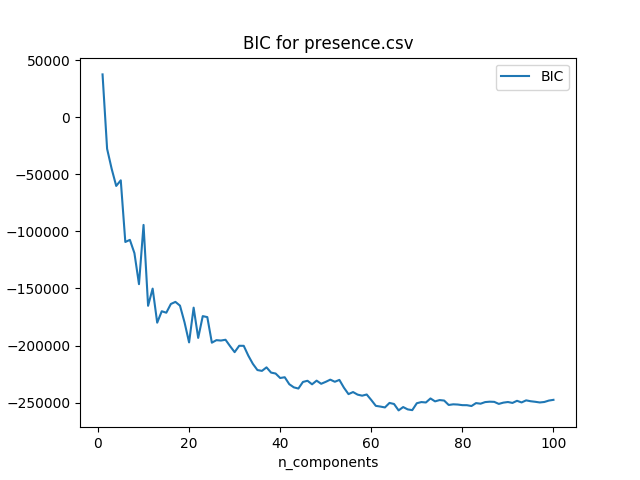

In [6]:
Image("presence.csv_bic.png")

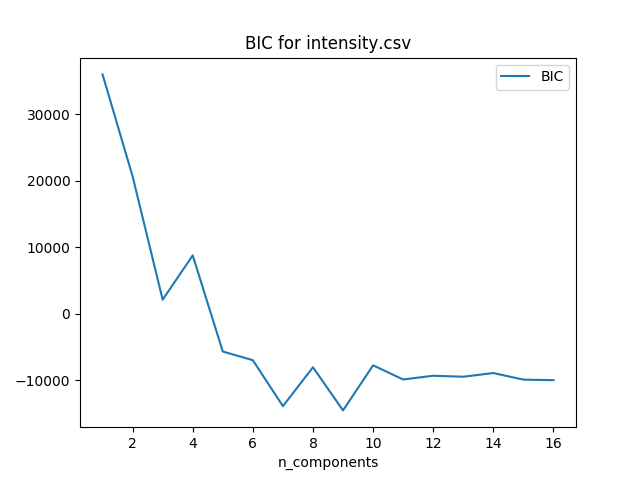

In [7]:
bic_analysis(X, "original", 16)
Image("original_bic.png")
Image("intensity.csv_bic.png")

## - GMM with n=9

In [8]:
# GMM
gmm = GMM(n_components=n, random_state=seed).fit(X)
labels = gmm.predict(X)
df['p_label'] = labels
probs = gmm.predict_proba(X)
df['probs'] = np.array(list(map(max, probs))).round(2)
m = gmm.means_

## - Use GMM means to find closest mean frames, export them and create SIRE Graphs

"select=eq(n\,44)"
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --e

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> mjpeg (native))
Press [q] to stop, [?] for help
[swscaler @ 0x562c22f74680] deprecated pixel format used, make sure you did set range correctly
Output #0, image2, to 'mean_frames_1/C0_mframe.jpg':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf57.83.100
    Stream #0:0(und): Video: mjpeg, yuvj420p(pc), 854x480 [SAR 1:1 DAR 427:240], q=2-31, 200 kb/s, 29.97 fps, 29.97 tbn, 29.97 tbc (default)
    Metadata:
      handler_name    : VideoHandler
      encoder         : Lavc57.107.100 mjpeg
    Side data:
      cpb: bitrate max/min/avg: 0/0/200000 buffer size: 0 vbv_delay: -1
frame=    1 fps=0.0 q=5.7 Lsize=N/A time=00:00:00.03 bitrate=N/A speed= 0.3x    
video:28kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
"select=eq(n\,17)"
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  

[swscaler @ 0x55c22599cbe0] deprecated pixel format used, make sure you did set range correctly
Output #0, image2, to 'mean_frames_1/C3_mframe.jpg':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf57.83.100
    Stream #0:0(und): Video: mjpeg, yuvj420p(pc), 854x480 [SAR 1:1 DAR 427:240], q=2-31, 200 kb/s, 29.97 fps, 29.97 tbn, 29.97 tbc (default)
    Metadata:
      handler_name    : VideoHandler
      encoder         : Lavc57.107.100 mjpeg
    Side data:
      cpb: bitrate max/min/avg: 0/0/200000 buffer size: 0 vbv_delay: -1
frame=    1 fps=0.0 q=5.3 Lsize=N/A time=00:00:01.40 bitrate=N/A speed=27.9x    
video:37kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
"select=eq(n\,68)"
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'Phoebe_dataset4/Phoebe_dataset4/videos/train/5.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.12.100
  Duration: 00:00:03.94, start: 0.000000, bitrate: 414 kb/s
    Stream #0:0(und): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt709), 854x480 [SAR 1:1 DAR 427:240], 410 kb/s, 32 fps, 29.97 tbr, 90k tbn, 59.94 tbc (default)
    Metadata:
      handler_name    : VideoHandler
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> mjpeg (native))
Press [q] to stop, [?] for help
[swscaler @ 0x556bdc5d4000] deprecated pixel format used, make sure you did set range correctly
Output #0, image2, to 'mean_frames_1/C6_mframe.jpg':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf57.83.100
    Stream #0:0(und): Video: mjpeg, yuvj420p(pc), 854x480 [SAR 1:1 DAR 427:240], q=2-31, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:238: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


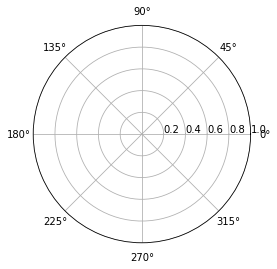

In [9]:
# make dataframe of video frames closest to the mean, labeled [0-8]
test_df = find_mean_frames(df, m, 1)

# export frames using mean information and put in mean_frames_1 folder
extract_mean_frames(test_df, train_video_path, 1)

# create sire radar charts & put in sire_graphs folder
make_radar(gmm.means_, n, 0, "sire_graphs", 1)

# create sire radar chart for selected frames
make_radar(test_df, n, 1, "sire_graphs", 1)

# Warnings don't affect analysis
# Not sure why blank sire graph shown below, but sire graphs found in folder

## Mean Frames & SIRE Graphs

Format is as follows:
- Image closest to mean
- SIRE graph for GMM Mean Values
- SIRE graph for Selected Frame's Mean Values

Two graphs are shown to see similarity to mean

### Cluster 0

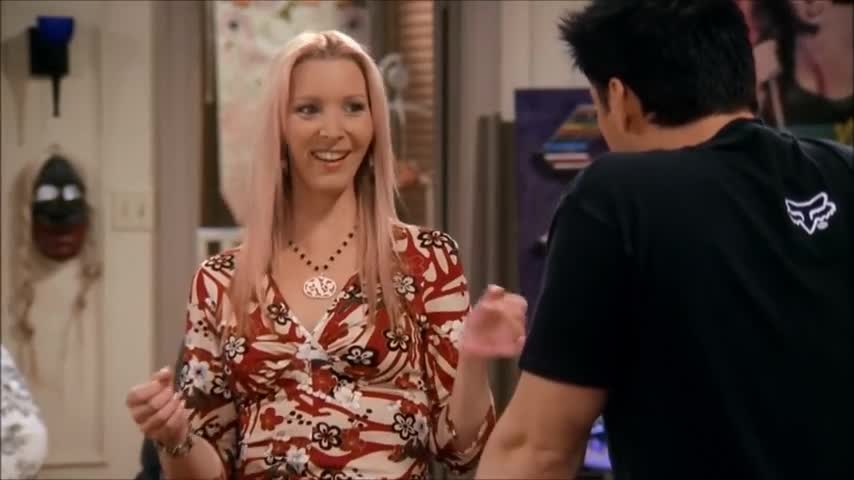

In [10]:
Image("mean_frames_1/C0_mframe.jpg") 


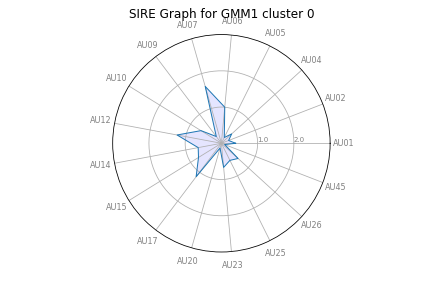

In [11]:
Image("sire_graphs/C0_sire.png")

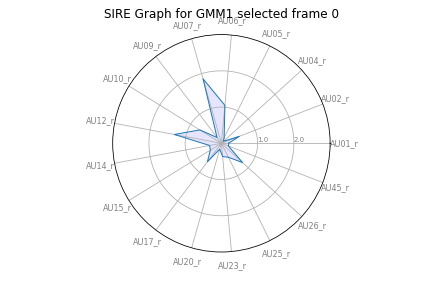

In [12]:
Image("sire_graphs/mean0_sire.png")

### Cluster 4

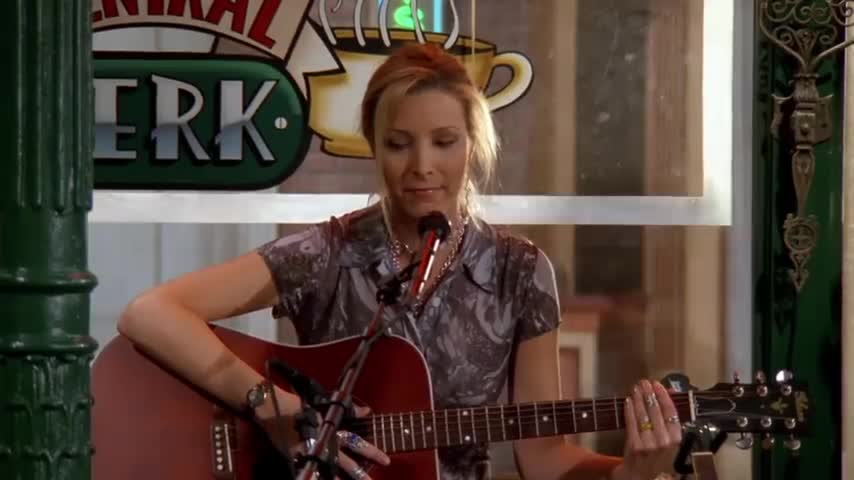

In [13]:
Image("mean_frames_1/C1_mframe.jpg") 


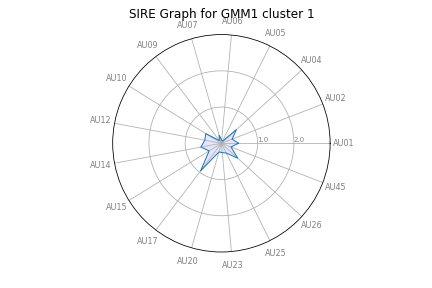

In [14]:
Image("sire_graphs/C1_sire.png")

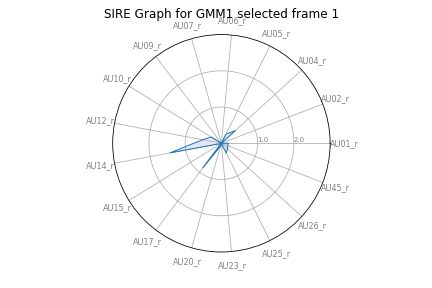

In [15]:
Image("sire_graphs/mean1_sire.png")

### Cluster 2

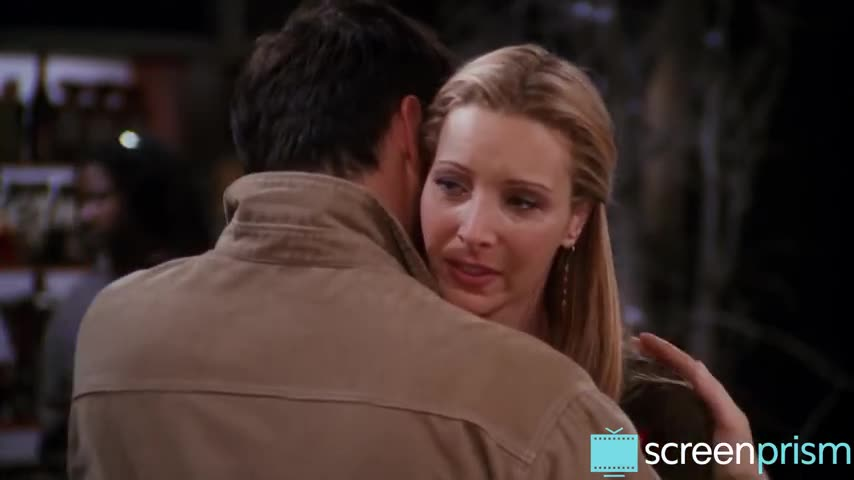

In [16]:
Image("mean_frames_1/C2_mframe.jpg") 


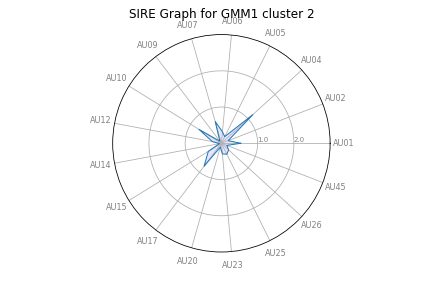

In [17]:
Image("sire_graphs/C2_sire.png")

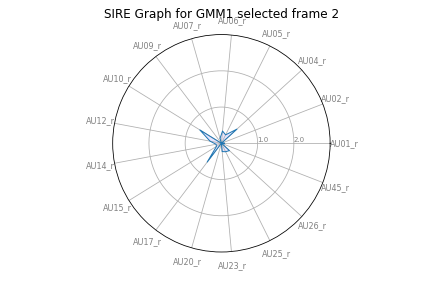

In [18]:
Image("sire_graphs/mean2_sire.png")

### Cluster 3

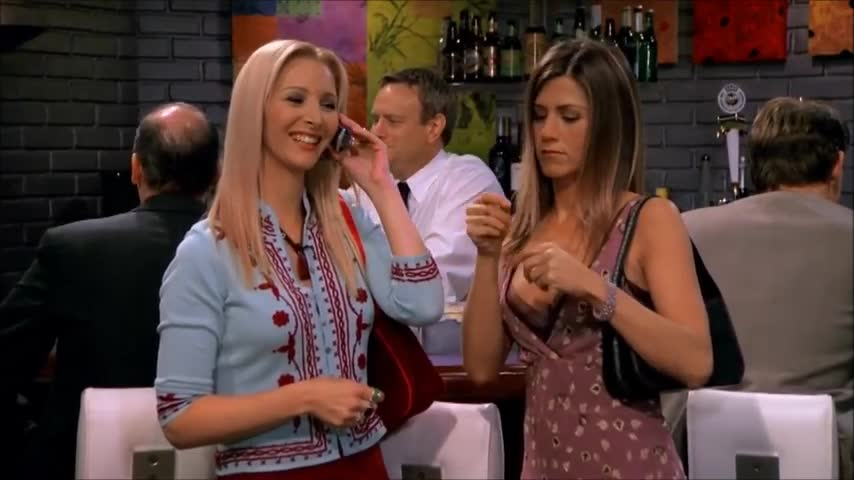

In [19]:
Image("mean_frames_1/C3_mframe.jpg") 


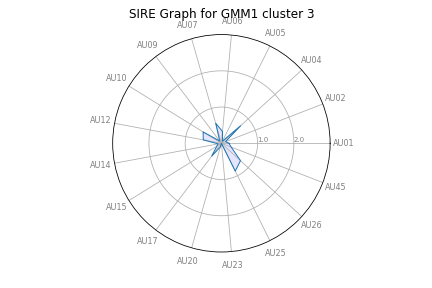

In [20]:
Image("sire_graphs/C3_sire.png")

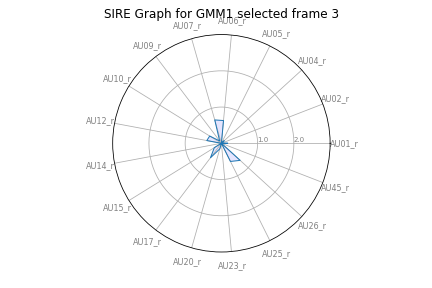

In [21]:
Image("sire_graphs/mean3_sire.png")

### Cluster 4

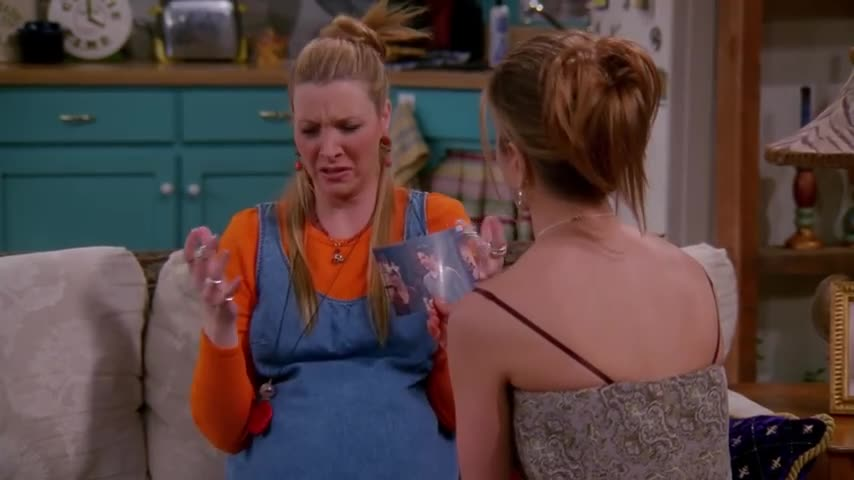

In [22]:
Image("mean_frames_1/C4_mframe.jpg") 


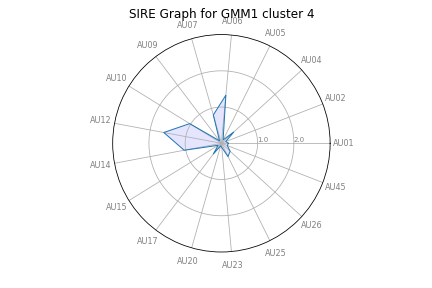

In [23]:
Image("sire_graphs/C4_sire.png")

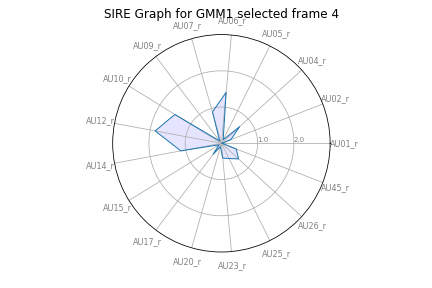

In [24]:
Image("sire_graphs/mean4_sire.png")

### Cluster 5

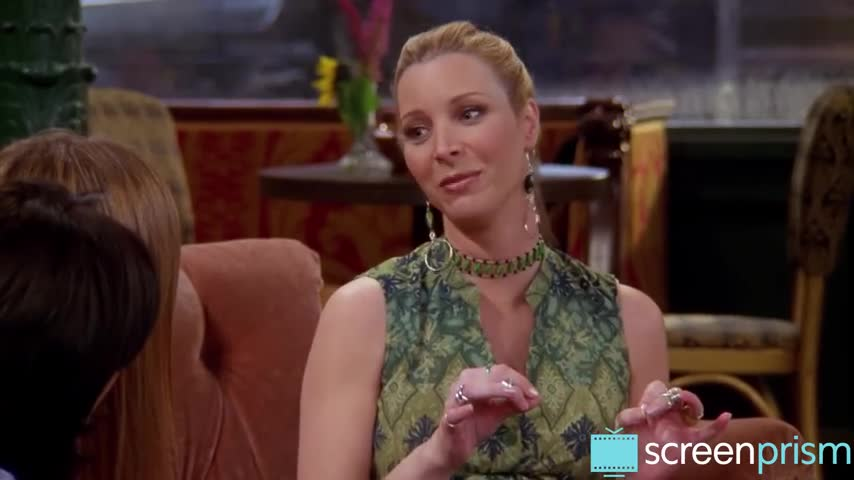

In [25]:
Image("mean_frames_1/C5_mframe.jpg") 


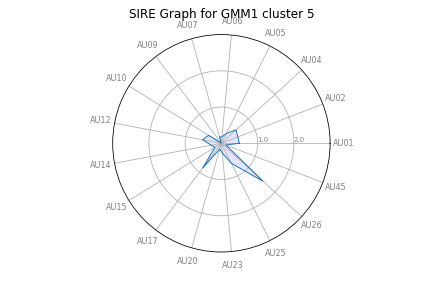

In [26]:
Image("sire_graphs/C5_sire.png")

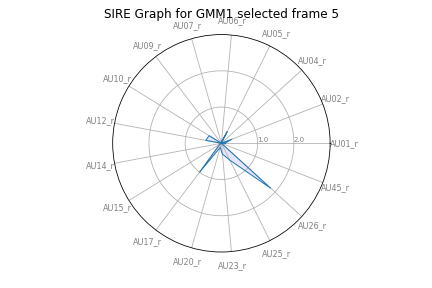

In [27]:
Image("sire_graphs/mean5_sire.png")

### Cluster 6

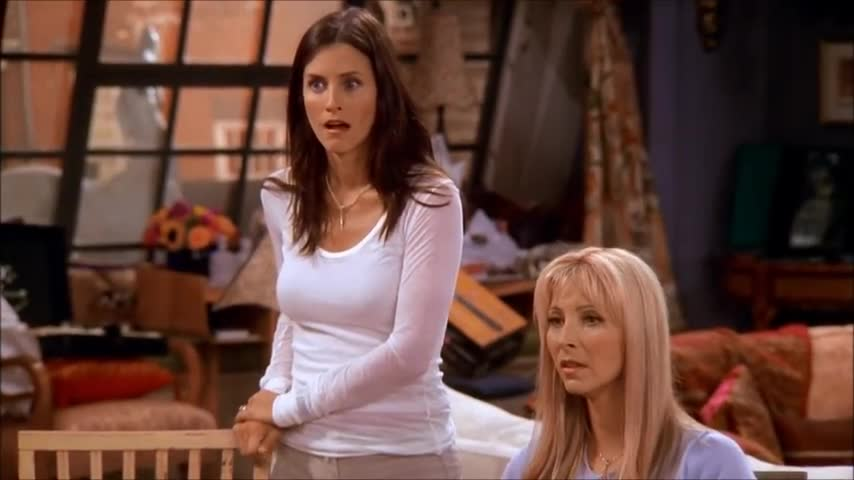

In [28]:
Image("mean_frames_1/C6_mframe.jpg") 


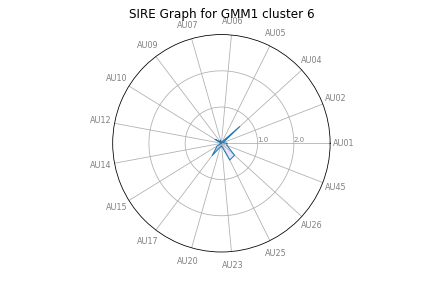

In [29]:
Image("sire_graphs/C6_sire.png")

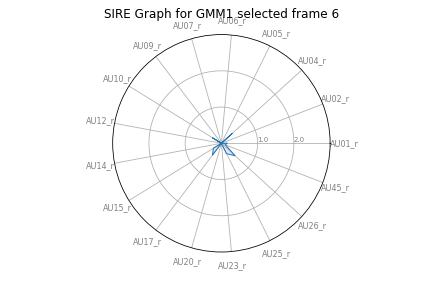

In [30]:
Image("sire_graphs/mean6_sire.png")

### Cluster 7

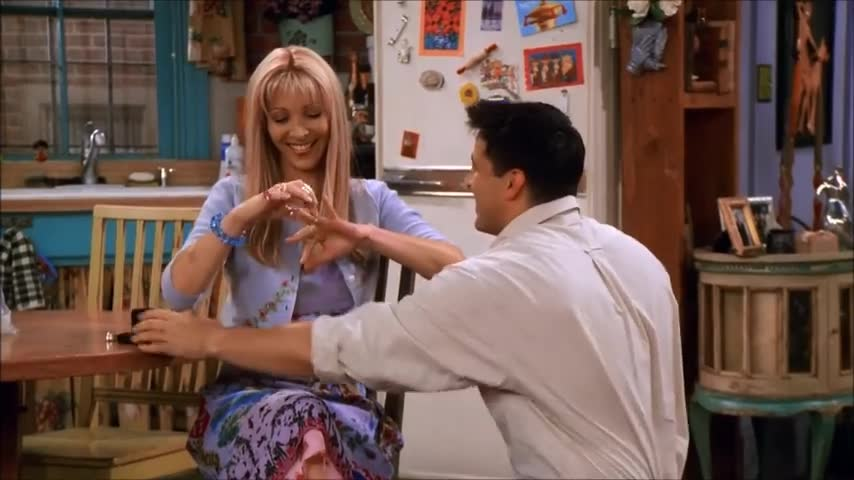

In [31]:
Image("mean_frames_1/C7_mframe.jpg") 


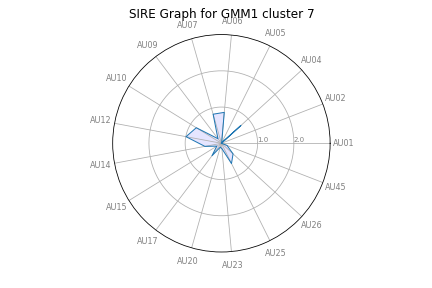

In [32]:
Image("sire_graphs/C7_sire.png")

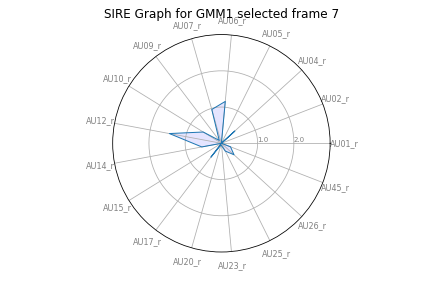

In [33]:
Image("sire_graphs/mean7_sire.png")

### Cluster 8

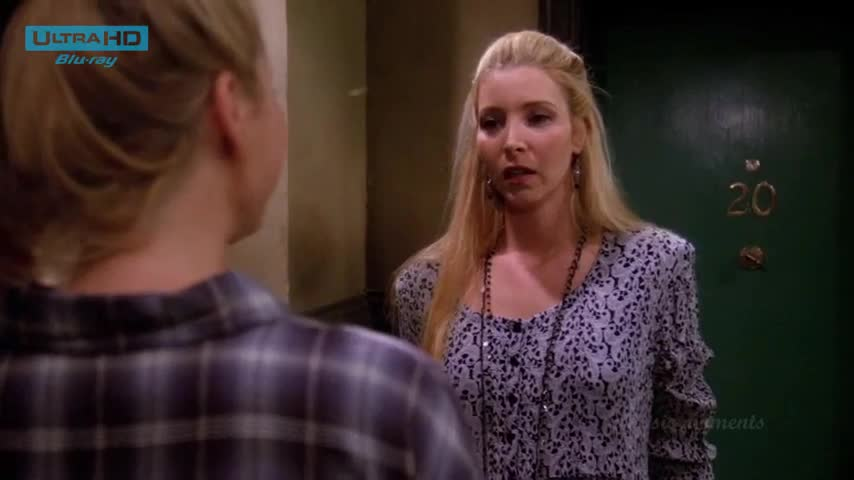

In [34]:
Image("mean_frames_1/C8_mframe.jpg") 


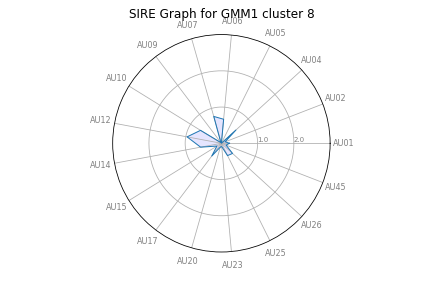

In [35]:
Image("sire_graphs/C8_sire.png")

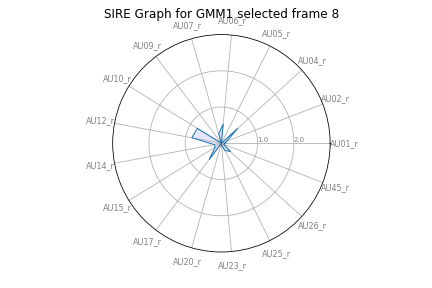

In [36]:
Image("sire_graphs/mean8_sire.png")

In [37]:
test_df

,csv_name,frame,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,...,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,p_label,probs,diff_sum
116,10.csv,43,0.20,0.53,0.08,0.17,1.05,1.85,0.20,0.70,...,0.36,0.64,0.17,0.37,0.43,0.79,0.21,0,0.86,3.416161
1711,29.csv,16,0.18,0.00,0.52,0.28,0.00,0.00,0.00,0.33,...,0.01,0.85,0.08,0.02,0.30,0.23,0.19,1,1.00,2.954490
1212,22.csv,76,0.08,0.00,0.58,0.26,0.34,0.14,0.00,0.70,...,0.16,0.65,0.00,0.23,0.26,0.30,0.01,2,0.70,3.337691
285,12.csv,48,0.17,0.00,0.10,0.00,0.63,0.67,0.08,0.38,...,0.23,0.50,0.16,0.00,0.56,0.70,0.00,3,0.68,2.354827
2120,36.csv,67,0.02,0.28,0.68,0.11,1.41,0.90,0.08,1.51,...,0.08,0.38,0.10,0.41,0.47,0.64,0.44,4,1.00,2.804072
949,21.csv,22,0.10,0.31,0.00,0.36,0.05,0.00,0.00,0.40,...,0.06,1.00,0.12,0.30,0.52,1.84,0.00,5,1.00,2.774339
2905,5.csv,51,0.15,0.00,0.40,0.00,0.00,0.00,0.00,0.29,...,0.26,0.41,0.00,0.01,0.32,0.51,0.12,6,1.00,1.588367
1804,3.csv,67,0.00,0.00,0.50,0.00,1.16,0.97,0.10,0.59,...,0.00,0.48,0.05,0.07,0.24,0.47,0.27,7,0.99,2.337151
1850,31.csv,8,0.10,0.16,0.61,0.00,0.53,0.27,0.01,0.78,...,0.20,0.56,0.00,0.07,0.22,0.34,0.07,8,1.00,1.765816


Information about the selected means is shown above. 
Labels are in the p_label column, and mixing coefficients are in the probs column. 
Next I will show a chart analyzing the graphs and frames to determine names for clusters 0 to 8

In [38]:
pd.read_csv("[419] A2 Expression Analysis.csv")

,Cluster Number,Highest AUs at mean,Highest AUs at frame closest to mean,Mixing Coefficient,My prediction of expression in frame,Determined Expression,Reasoning
0,Cluster 0,"7: Lid Tightener, 17: Chin Raiser, 12: Lip Cor...","7: Lid Tightener, 12: Lip Corner Puller, 6: Ch...",0.86,Surprise,Joy/Laughter,"Not enough AUs to determine surprise [1,2,5,26..."
1,Cluster 1,"17: Chine Raiser, 26: Jaw Drop, 4: Brow lowere...","14: Dimpler, 17: Chin Raiser,",1.00,Embarassed,Neutral/Embarassed,"Values are low, and sire for selected frame do..."
2,Cluster 2,"4: Brow Lowerer, 17: Chin Raiser, 10: Upper Li...","10: Upper Lip Raiser, 17: Chin Raiser, 4: Bro...",0.70,Sad,Sad,Sad has AUs 1+4+15. The expression in frame lo...
3,Cluster 3,"25: Lips part, 26: Jaw Drop, 4: Brow Lowerer, ...","26: Jaw Drop, 7: Lid TIghtener, 6: Cheek Rais...",0.68,Happy,Happy/Bashful,"Happy, like joy, has AUs 6+12. The mean sire, ..."
4,Cluster 4,"12: Lip Corner Puller, 6: Cheek Raiser, 14: Di...","12: Lip Corner Puller, 6: Cheek Raiser, 14: Di...",1.00,Disgust,Disgust,"Looking at the frame, and watching the video i..."
5,Cluster 5,"26: jaw drop, 17: chin raiser, 12: lip corner ...","26: Jaw Drop, 17: chin raiser, 25: Lips part,...",1.00,Neutral,Neutral/annoyed,This frame is strange. The most intense AU in ...
6,Cluster 6,"26: jaw drop, 25: Lips Part, 17: chin raiser, ...","26: jaw drop, 25: Lips Part, 17: chin raiser, ...",0.99,Contempt,Surprise/Sad,"All AU intensities under 1.0, making me think ..."
7,Cluster 7,"12: Lip Corner Puller, 6: Cheek Raiser, 10 : U...","12: Lip Corner Puller, 6: Cheek Raiser, 10 : U...",NaN,happy,"Happy, low activation","There have been many instances of 12+6, which ..."
8,Cluster 8,"17: chin raiser, 10: Upper Lip Raiser, 4: Brow...","17: chin raiser, 10: Upper Lip Raiser, 4: Brow...",NaN,fear,sadness/fear/anxious,"Looking mostly visibly in the frame, Phoebe lo..."


Notes:
- Some AUs might be activated due to speaking 
- Lack of AUs could determine expressions too
- Could be a mixture of different emotions
- I know csv is hard to see. I have also included a pdf to view externally
- Gaussian means have been given unique names and included in a dictionary later on


# 2. Dimensionality Reduction

In [39]:
# Umap -- Code adapted from https://umap-learn.readthedocs.io/en/latest/basic_usage.html 
         # And from https://umap-learn.readthedocs.io/en/latest/clustering.html
    
# -- Init data
unscaled_data = X.values

# -- Reduce dimensions of data with Umap
#reducer = umap.UMAP()
reducer = umap.UMAP(
        n_neighbors=500, 
        min_dist=0.60, 
        n_components=2,
        random_state=seed
        )

embedding = reducer.fit_transform(unscaled_data)

umap with default parameters do not create an inflection point. 

Changing n_neighbors closer to %25 of data_samples (the max) alows umap to concentrate on larger neighbourhoods

Changing min_dist seems to help find a good inflection point using bic

source: https://umap-learn.readthedocs.io/en/latest/parameters.html

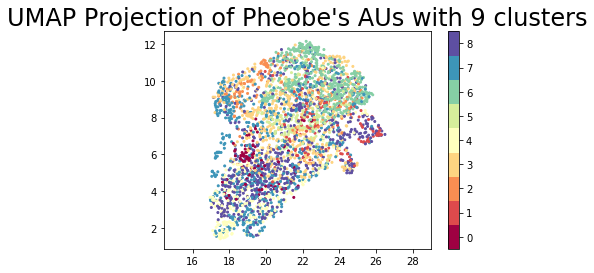

In [40]:
# -- Plot UMAP to visualize 2D AU data
plot_umap(embedding, 9, df.p_label, "umap_plot_hdim_labels")

We can now visualize Pheobe's AUs in two dimensions.

Using labels from the first classifier, we can see some initial clusterings, but we will have to re-cluster

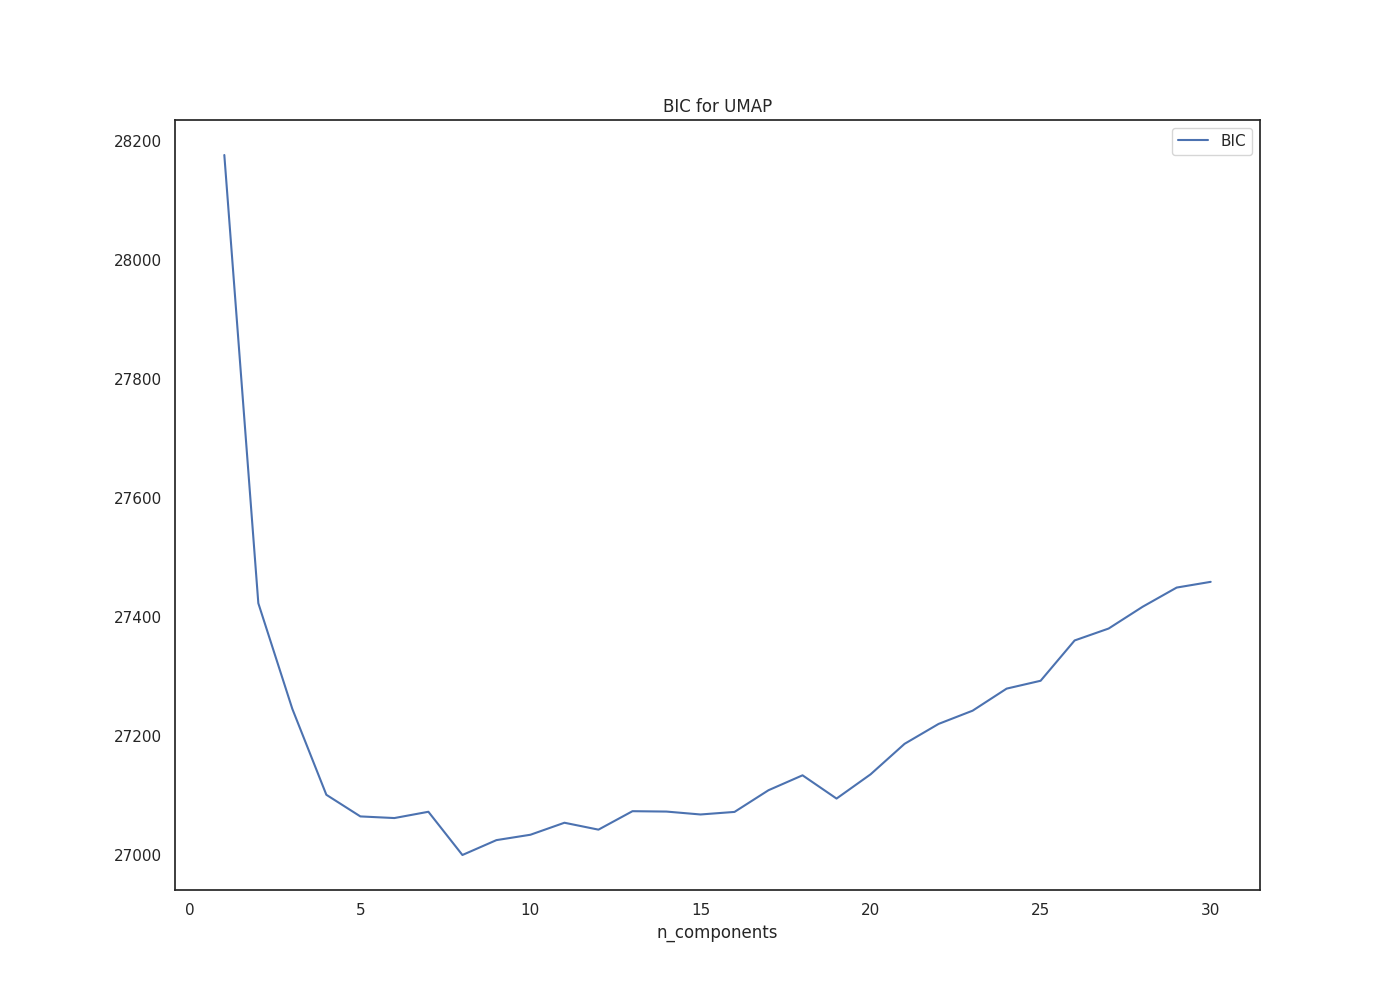

In [41]:
Image("UMAP_bic.png")

We can see UMAP has an inflection point at 8, and we will create 8 clusters using UMAP 2-D data

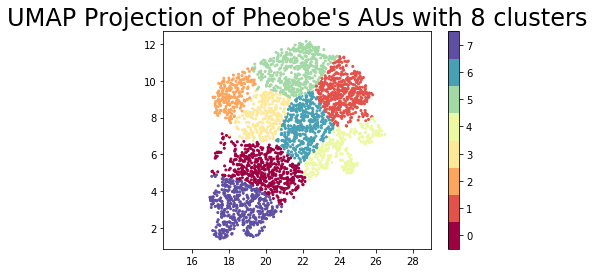

In [42]:
n_umap = 8

# Reformat UMAP data for GMM
df['dim1'] = embedding[:, 0]
df['dim2'] = embedding[:, 1]
X2 = df[['dim1', 'dim2']]

# Re-created GMM
gmm_umap = GMM(n_components=n_umap, random_state=seed).fit(X2)
labels_umap = gmm_umap.predict(X2)
df['p_label_umap'] = labels_umap
probs_umap = gmm_umap.predict_proba(X2)
df['probs_umap'] = np.array(list(map(max, probs_umap))).round(2)
m_umap = gmm_umap.means_

plot_umap(embedding, n_umap, df.p_label_umap, "umap_plot_ldim_labels")

In [43]:
# Compare High-Dimensional Labels to Low-Dimensional Labels
print("adjusted rand score:", adjusted_rand_score(labels, labels_umap))
print("adjusted mutual score:", adjusted_mutual_info_score(labels, labels_umap))



adjusted rand score: 0.106364587367392
adjusted mutual score: 0.20782694890084685


Using the adjusted rand and mutual information scores, it seems obvious that
clustering on this lower dimensional space did not go so well.

Following https://umap-learn.readthedocs.io/en/latest/clustering.html it seems as though distances were not preserved well.

I was confused aboutthe 2D data at first, wondering why it was not similar to high dimensional data. I realized that lower dimensional data would need to be re-clustered, finding new pattern, and classifying new expressions.


## Mean Frames & SIRE Graphs For UMAP Data

### Cluster 0

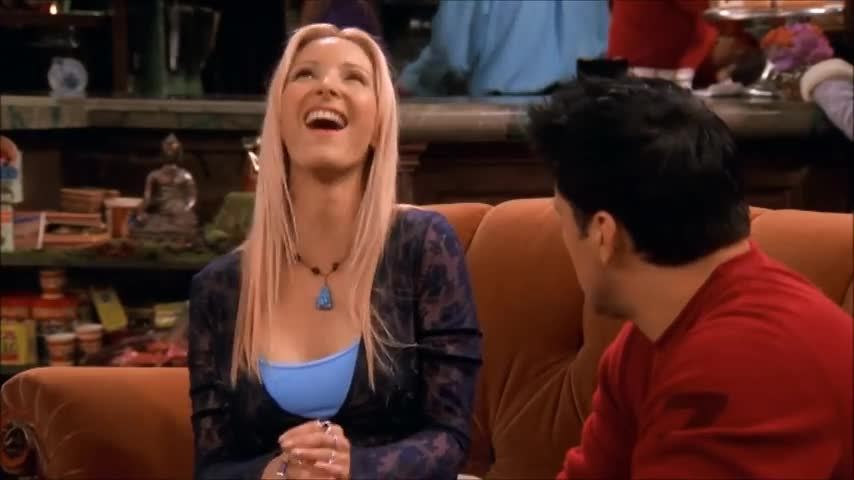

In [44]:
Image("mean_frames_2/C0_mframe.jpg") 


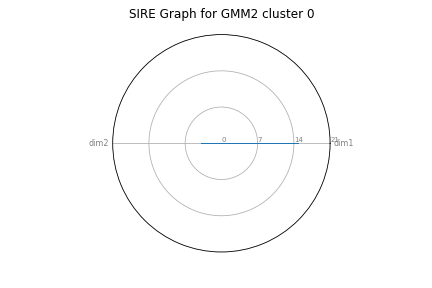

In [45]:
Image("sire_graphs_2/C0_sire.png")

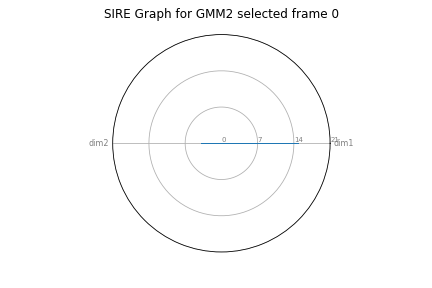

In [46]:
Image("sire_graphs_2/mean0_sire.png")

### Cluster 1

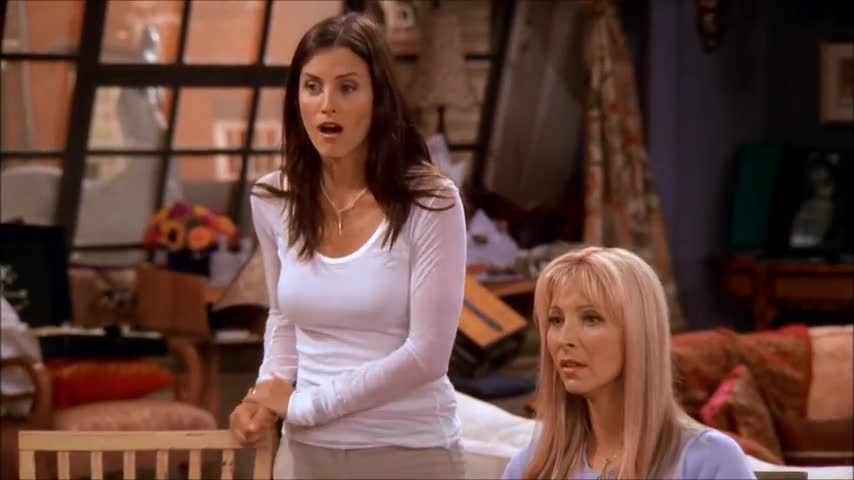

In [47]:
Image("mean_frames_2/C1_mframe.jpg") 


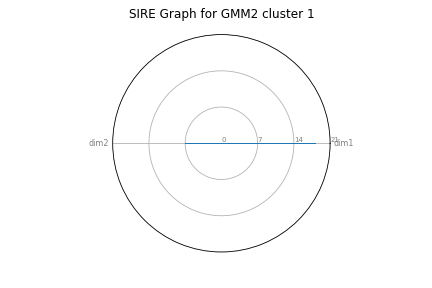

In [48]:
Image("sire_graphs_2/C1_sire.png")

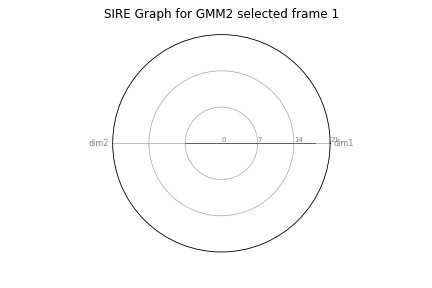

In [49]:
Image("sire_graphs_2/mean1_sire.png")

We can see with less dimensions, selected frames are very close to the mean

I will not show anymore SIRE graphs since the are very similar. You can see them all in the sire_graphs_2 folder if you would like :)

### Cluster 2

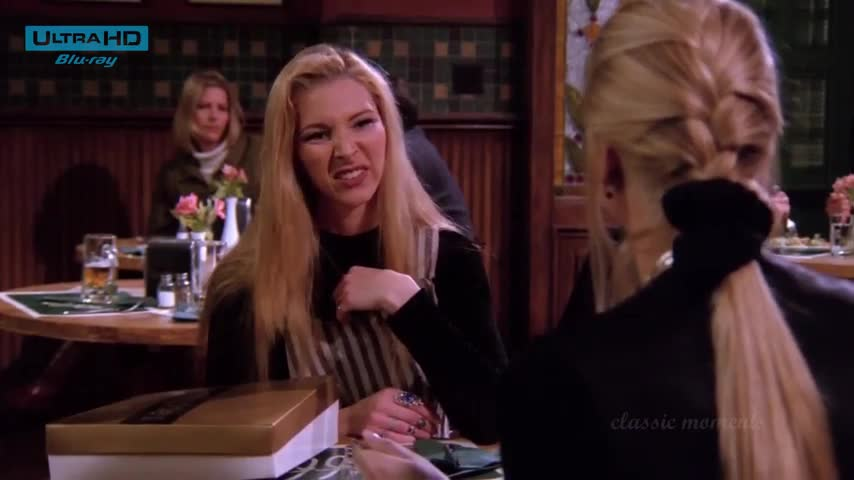

In [50]:
Image("mean_frames_2/C2_mframe.jpg") 


### Cluster 3

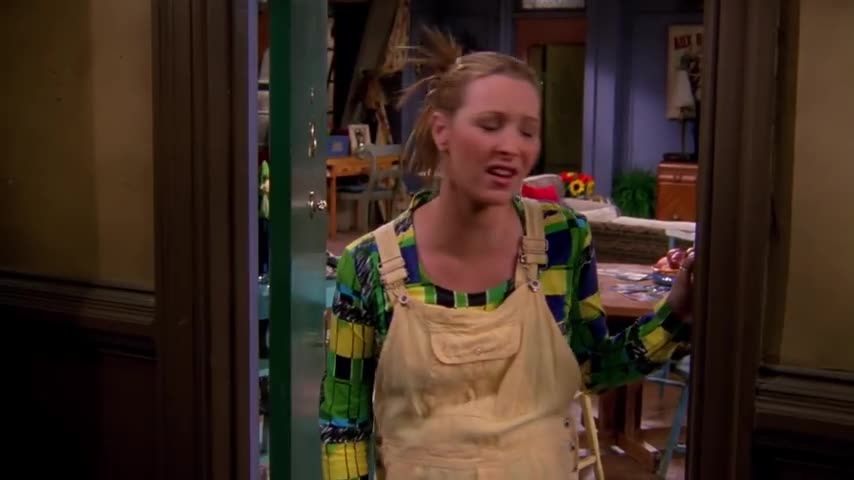

In [51]:
Image("mean_frames_2/C3_mframe.jpg") 


### Cluster 4

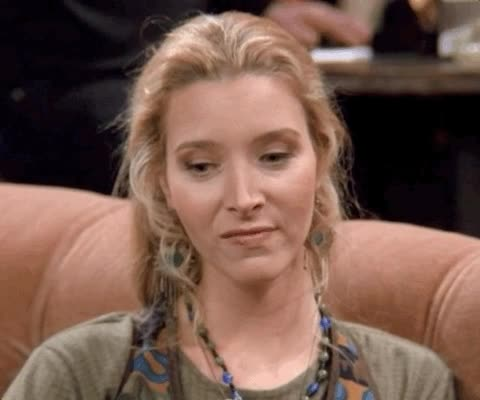

In [52]:
Image("mean_frames_2/C4_mframe.jpg") 


### Cluster 5

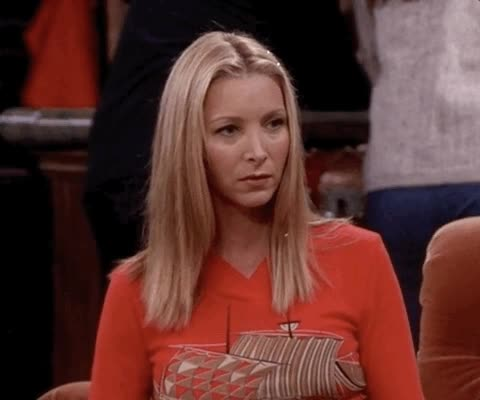

In [53]:
Image("mean_frames_2/C5_mframe.jpg") 


### Cluster 6

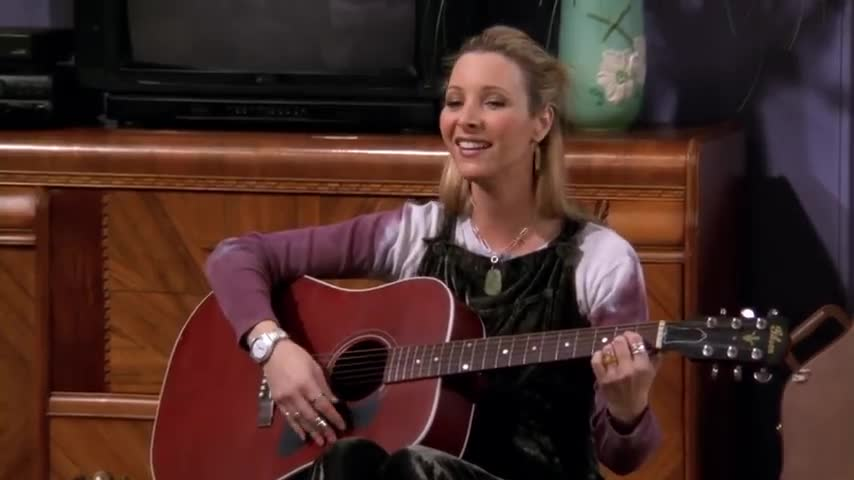

In [54]:
Image("mean_frames_2/C6_mframe.jpg") 


### Cluster 7

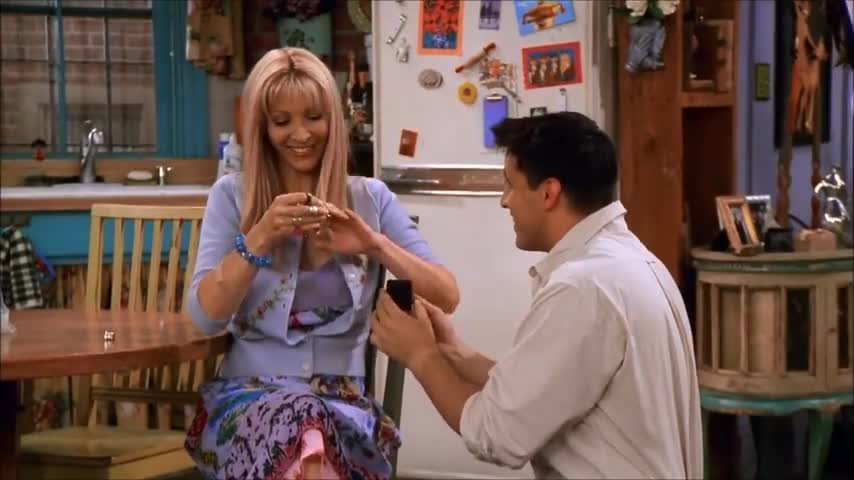

In [55]:
Image("mean_frames_2/C7_mframe.jpg") 


## Classification of both GMM models

In [57]:
'''
GMM1 Classification
===========================
'''
gmm1_labels = {
0:"Joy/Laughter",
1:"Neutral/Embarassed",
2:"Sad",
3:"Happy/Bashful",
4:"Disgust",
5:"Neutral/Annoyed/Upset",
6:"Surpise/Sad",
7:"Happy (Low Activation)",
8:"Sadness/Fear/Anxious"
}
'''
GMM2 Classification
===========================
'''
gmm2_labels = {
0:"excitement/surprise",
1:"neutral or fear",
2:"disgust",
3:"sad",
4:"contempt",
5:"upset/angry",
6:"happy, low activation or embaressment",
7:"happy, high activation"
}

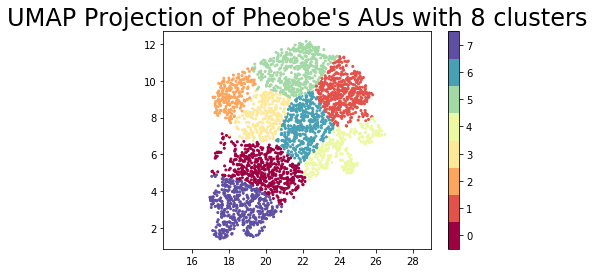

In [56]:
plot_umap(embedding, n_umap, df.p_label_umap, "umap_plot_ldim_labels")

## Layperson's description of UMAP Gaussian Components

I have provided the visual 2D AU data for reference

First, we see happy (high activation) in purple, next to excitement/surprise in red.

From here I would like to hypothesize two clusters sharing a border will share similar emotional states. Using the first two emotions as an example, happiness is quite similar to excitement/surprise.

In yellow is sadness, bluish green is happy (low activation)/embarassment. Embarassment can might be linked to sadness, and might be similar to excitement in red. 

Lime green is contempt, maybe linking with embarassment and excitement at borders, and orange being fear/neutral expressions. Fear/Neutral seems link a strange mix, we could call it low activation fear.

Green is upset/anger, and light orange is disgust.

It is interesting to see happiness (high activation) at one end of data cluster, and upset, disgust, fear, and sadness at the other end. 

These clusters seem to make real sense.

## 3. Soft Classification

### GMM 1 Classification

In [58]:
# --- init & Format
df_51 = preprocess(test_csv_path + "51.csv", confidence_thresh)
df_52 = preprocess(test_csv_path + "52.csv", confidence_thresh)
df_53 = preprocess(test_csv_path + "53.csv", confidence_thresh)

# --- GMM1
# --- --- remove features
X_51 = df_51.drop(columns=['csv_name', 'frame', 'face_id', 'confidence',
                           'success'])
X_52 = df_52.drop(columns=['csv_name', 'frame', 'face_id', 'confidence',
                           'success'])
X_53 = df_53.drop(columns=['csv_name', 'frame', 'face_id', 'confidence',
                           'success'])

# --- --- Predict & Label DFs
labels_51 = gmm.predict(X_51)
likelihood_51 = gmm.score_samples(X_51)
df_51['p_label'] = labels_51
df_51['likelihood_diff'] = abs(gmm.score(X_51) - likelihood_51).round(2)
probs_51 = gmm.predict_proba(X_51)
df_51['probs'] = np.array(list(map(max, probs_51))).round(2)

labels_52 = gmm.predict(X_52)
likelihood_52 = gmm.score_samples(X_52)
df_52['p_label'] = labels_52
df_52['likelihood_diff'] = abs(gmm.score(X_52) - likelihood_52).round(2)
probs_52 = gmm.predict_proba(X_52)
df_52['probs'] = np.array(list(map(max, probs_52))).round(2)

labels_53 = gmm.predict(X_53)
likelihood_53 = gmm.score_samples(X_53)
df_53['p_label'] = labels_53
df_53['likelihood_diff'] = abs(gmm.score(X_53) - likelihood_53).round(2)
probs_53 = gmm.predict_proba(X_53)
df_53['probs'] = np.array(list(map(max, probs_53))).round(2)


I created A likelihood difference variable to be tested against a threshold set in the parameter section (In [4]). The threshold was set to 14. 

Likelihood difference takes the average likelihood score, and subtracts the absolute value of the score set for each data row. High values meant low likelihood. Any score over 14 was removed from analysis.

### Predictions

In [63]:
# --- --- Calculate confidence level of each label

pred_51_1, conf_51_1 = label_confidence(df_51, 1)
pred_52_1, conf_52_1 = label_confidence(df_52, 1)
pred_53_1, conf_53_1 = label_confidence(df_53, 1)
print("video 51 predicted as", gmm1_labels[pred_51_1], "with GMM1")
print("video 52 predicted as", gmm1_labels[pred_52_1], "with GMM1")
print("video 53 predicted as", gmm1_labels[pred_53_1], "with GMM1")

video 51 predicted as Surpise/Sad with GMM1
video 52 predicted as Happy (Low Activation) with GMM1
video 53 predicted as Sadness/Fear/Anxious with GMM1


In [61]:
print("video 51 GMM1 confidence scores:", conf_51_1)
print("video 52 GMM1 confidence scores:", conf_52_1)
print("video 53 GMM1 confidence scores:", conf_53_1)

video 51 GMM1 confidence scores: {6: 0.43, 7: 0.36, 3: 0.21}
video 52 GMM1 confidence scores: {7: 0.28, 3: 0.2, 5: 0.16, 6: 0.12, 8: 0.08, 2: 0.08, 1: 0.04, 0: 0.04}
video 53 GMM1 confidence scores: {8: 0.38, 4: 0.38, 7: 0.15, 0: 0.08}


A detailed view of how confidence scores are calculated can be found in the label_confidence() function at the beginning of this notebook, but I will briefly explain scores here:

The classifier labeled each frame, and dataframe rows were aggregated and counted by labels. The score basically label_count/sumof_labeled_rows.

51 is listed as surprise, but also very close to happiness (low activation).

52 is Happy (Low activation), but close to happy/bashful. This expression is hard to label even without a computer. But Pheobe looks like shes thinking of something funny, or could be blushing due to someone giving her a compliment. 

53 is tied between sadness/fear/anxious, and disgust. She probably not feeling disgusted, but I can see how her expression might look like disgust without context. She definitly looks anxious, but not sad. This expression tripped the model up. 

### GMM2 UMAP Classification

In [67]:
# GMM2: Umap ============================================================

# --- Init data
unscaled_data_51 = X_51.values
unscaled_data_52 = X_52.values
unscaled_data_53 = X_53.values

# --- Reduce dimensions of data with Umap model
reducer_2 = umap.UMAP(
        n_neighbors=10, 
        min_dist=0.60, 
        n_components=2,
        random_state=seed
        )
# I tried to make n_neighbors close to %25 of the longest gif (47ish frames) to stay similar to previous model
"""
reducer_2 = umap.UMAP()
"""
embedding_51 = reducer_2.fit_transform(unscaled_data_51)
embedding_52 = reducer_2.fit_transform(unscaled_data_52)
embedding_53 = reducer_2.fit_transform(unscaled_data_53)

# --- Reformat UMAP data for GMM
df_51['dim1'] = embedding_51[:, 0]
df_51['dim2'] = embedding_51[:, 1]
X2_51 = df_51[['dim1', 'dim2']]

df_52['dim1'] = embedding_52[:, 0]
df_52['dim2'] = embedding_52[:, 1]
X2_52 = df_52[['dim1', 'dim2']]

df_53['dim1'] = embedding_53[:, 0]
df_53['dim2'] = embedding_53[:, 1]
X2_53 = df_53[['dim1', 'dim2']]

# --- Re-created GMM

#gmm_umap_51 = GMM(n_components=n_umap, random_state=seed).fit(X2)
labels_umap_51 = gmm_umap.predict(X2_51)
df_51['p_label_umap'] = labels_umap_51
probs_umap_51 = gmm_umap.predict_proba(X2_51)
df_51['probs_umap'] = np.array(list(map(max, probs_umap_51))).round(2)

labels_umap_52 = gmm_umap.predict(X2_52)
df_52['p_label_umap'] = labels_umap_52
probs_umap_52 = gmm_umap.predict_proba(X2_52)
df_52['probs_umap'] = np.array(list(map(max, probs_umap_52))).round(2)

labels_umap_53 = gmm_umap.predict(X2_53)
df_53['p_label_umap'] = labels_umap_53
probs_umap_53 = gmm_umap.predict_proba(X2_53)
df_53['probs_umap'] = np.array(list(map(max, probs_umap_53))).round(2)


### Predictions

In [70]:
pred_51_2, conf_51_2 = label_confidence(df_51, 2)
pred_52_2, conf_52_2 = label_confidence(df_52, 2)
pred_53_2, conf_53_2 = label_confidence(df_53, 2)
print("video 51 predicted as", gmm2_labels[pred_51_2], "with model 2 and confidence scores:", conf_51_2)
print("video 52 predicted as", gmm2_labels[pred_52_2], "with model 2 and confidence scores:", conf_52_2)
print("video 53 predicted as", gmm2_labels[pred_53_2], "with model 2 and confidence scores:", conf_53_2)

video 51 predicted as excitement/surprise with model 2 and confidence scores: {0: 1.0}
video 52 predicted as excitement/surprise with model 2 and confidence scores: {0: 1.0}
video 53 predicted as happy, high activation with model 2 and confidence scores: {7: 1.0}


There seems to be inherent bias involved with these classifications. 51 and 53 seem correct, Pheobe is surprised in 51, and very happy in 53, but I doubt she is excited and/or surprised in 52.

This seems really strange, as the confidence level is at 100%. It is possible that new values set in the umap_transform function has skewed results. I used a new UMAP variable, as I could not use n_neighbors=500 due to the test frames not having more than 500 samples. I did not know any other way to make the script work otherwise.

### Exporting Dataframes for further analysis

In [ ]:

# export dataframe
df.to_csv('pheobe_data.csv')
df_51.to_csv('data_51.csv')
df_52.to_csv('data_52.csv')
df_53.to_csv('data_53.csv')

## Miscellaneous Text & Analysis

- proposed components and qualitative descriptions in [38, 56,57]
- examples of best and worst classifications: 
    - best: tied between GMM2-53, and GMM2-51; both were correct and scored 100%
    - worst: tied between GMM1-53, as it couldn't determine the strongest emotions, and GMM2-52, as it incorrectly labeled the expression, and still listed 100% confidence
    
    
- Discussion on context and examples of where classification using AUs alone may fail. What extra features might we need to extract?
    - As we've learned during lecture, context matters when describing emotions. We are not entirely sure what Pheobe's emotions are, without figuring out what episodes gifs are from, and knowing who/what she is interacting with. 
    - I noticed AU14 chin raiser was activated often, when I concidered it to not be actived by my eye. I have a feeling Pheobe has a prominent chin, and it might interfere with Open_Face. This makes me think other instances of Open_face thinking AUs have activated when they haven't. 
    - I noticed gaze information was found in the all_features_multiperson csvs, and this information could help our models classify more accurately. For example, embarassment includes a looking away gaze, and I believe the models were confused by embarassment. 
    
    
- Discussion on sub-emotions:
    - Smiles did not all fall into one cluster using umap. I found different levels of smiling, for example, with happy (low activation) and happy (high activation). These expressions were concidered 2 different clusters, but did share a border in the UMAP data. 
    
    
- Discussion of dataset:
    - Results would definitely be limited, and I guess biased as well. For example, If we tried to classify a man's facial expressions, I bet the model would be confused by differing facial structure. Same with older people; people classified that are older than Pheobe might introduce wrinkles and such that might be picked up by models incorrectly. Otherwise, expressions would be biased towards Pheobe's expressions found in the training section. If someone had an expression concidered to be happy (high activation), the model might classify the expression as (low activation) as Pheobe is a very smiley person, and might smile more than others, skewing results. 